In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from numpy.fft import fft,ifft,ifftshift, fftshift

# GBM + Jump

In [3]:
# Parameters
npaths = 20000  # Number of paths to be simulated
T = 1  # Time horizon
nsteps = 200  # Number of timesteps
dt = T / nsteps  # Size of timesteps
t = np.linspace(0, T, nsteps + 1)  # Discretization of the time grid
mu = 0.2  # Drift for ABM
sigma = 0.55  # Volatility/diffusion term for ABM . increasing can increase size of jumps
lamb = 0.5  # Rate of arrival for Poisson Process. increasing will increase the number of jumps
eta1 = 10  # Parameter for upward jumps
eta2 = 10  # Parameter for downward jumps
p = 0.5  # Probability of an upward jump
S0 = 1  # Initial stock price

Text(0.5, 1.0, 'Paths of a Kou Jump-Diffusion process dX(t) = $\\mu$dG(t) + $\\sigma$dW(G(t))')

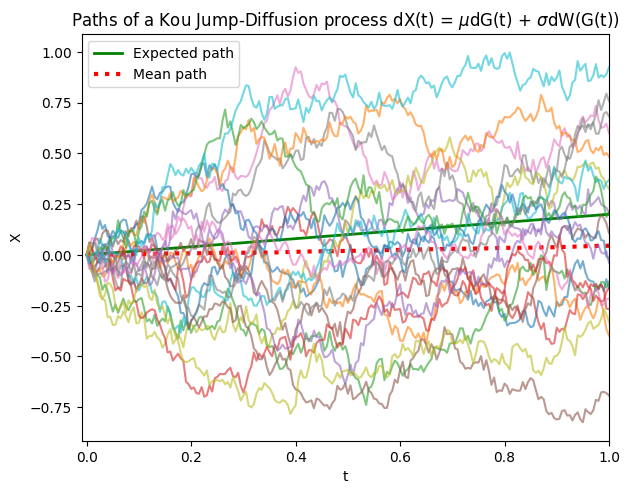

In [4]:
## Monte Carlo
#Bilateral Exponential R.V.     
U = np.random.rand(nsteps, npaths)
Z = ((-1/eta1)*(np.log((1-U)/p))*(U>=1-p)) + ((1/eta2)*np.log(U/(1-p))*(U<1-p))
# randLaplace = np.where(U < p, np.random.laplace(scale=1/eta1, size=(nsteps, npaths)), np.random.laplace(scale=1/eta2, size=(nsteps, npaths)))

# ## Monte Carlo
# # Compute the increments of the arithmetic Brownian motion X = log(S/S0)==>S = S0 * np.exp(X)
dW = (mu-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.randn(nsteps,npaths)

# Compute the increments of the Kou Jump
dP = np.random.poisson(lamb*dt,(nsteps,npaths))

dJ = dP * Z # dJ = (np.exp(Z)-1)*dP
# dJ = mu * dP + sigma*randLaplace* np.sqrt(dP) - Same 
dS = dW + dJ

S = np.vstack([np.zeros((1,npaths)), np.cumsum(dS, axis=0)])
# dS = np.insert(dS, 0, S0, axis=0)
# S = np.cumsum(dS, axis=0)

t = np.linspace(0, T, nsteps+1) 
## Expected, mean and sample path
plt.figure()
EX = (mu+lamb*(p/eta1 - (1-p)/eta2))*t # expected path
plt.plot(t,EX,'green',lw=2, label='Expected path')
plt.plot(t,np.mean(S,axis=1),color='r', linestyle='dotted', lw=3, label='Mean path')
plt.plot(t,S[:,::1000], alpha=0.6)
plt.legend(loc=0)
plt.xlabel('t')
plt.ylabel('X')
plt.xlim(-0.01,T)
plt.tight_layout()
plt.title(r'Paths of a Kou Jump-Diffusion process dX(t) = $\mu$dG(t) + $\sigma$dW(G(t))')

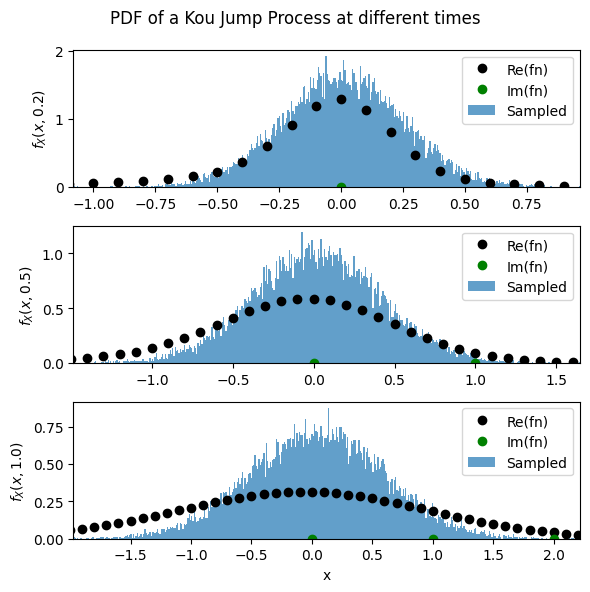

In [14]:
# Probability density function at different times
# x = np.arange(-1, 1, dt)
# xx = x[:-1] + dt / 2  # Adjust to match the number of histogram values

# ### Fourier transform estimation of PDF 
# fig, ax = plt.subplots(3,1, figsize=(6,6))
# for i,time in enumerate([40,100,-1]):
#     hist_values, _ = np.histogram(S[time,:],density=True,bins=x)
#     ax[i].bar(xx,hist_values, width=dt)
#     ax[i].set_ylabel(f'$f_X(x, {t[time]:.1f})$')
# plt.suptitle('PDF of a Kou Jump Diffusion Process at different times')
# plt.xlabel('x')
# plt.tight_layout()

#  ----- OR ------

# fig, ax = plt.subplots(3,1, figsize=(6,6))
# for i,time in enumerate([40,100,-1]):
#     ax[i].hist(S[time,:],density=True,bins=nsteps, alpha=0.7)
#     ax[i].set_ylabel(f'$f_X(x, {t[time]:.1f})$')
#     ax[i].set_xlim(-1.5,1.5)

# FT Approx of Pdf using IFFT
N = 512
dx = 0.1
upperx = N * dx
x = dx * np.arange(-N/2, N/2)

# GRID IN FOURIER SPACE (Pulsation)
dxi = (2*np.pi)/(N*dx) #Grid step size in fourier space
upperx = N*dxi # Upper truncation limit in fourier space
xi = dxi * np.arange(-N/2, N/2)  # grid in Fourier space

# Frequency space: nu
# expon1 = lamb*((p*eta1)/(eta1-1j*(2*np.pi*nu)) + ((1-p)*eta2)/(eta2+1j*(2*np.pi*nu)) - 1)
# char_func1 = np.exp((1j*(2*np.pi*nu)*mu - 0.5*((2*np.pi*nu)*sigma)**2)*T + expon1*T)

fig, ax = plt.subplots(3,1, figsize=(6,6))
for i,time in enumerate([40,100,-1]):
    ax[i].hist(S[time,:],density=True,bins=nsteps, alpha=0.7)

    # Pulsation space: 
    phi_z = p*(eta1/(eta1-1j*xi)) + (1-p)*(eta2/(eta2+1j*xi))
    char_func = np.exp(-0.5*(t[time]*xi)**2 + lamb *(phi_z-1))
    f_X = fftshift(fft(ifftshift(char_func))) / upperx
    ax[i].plot(x,np.real(f_X), 'ko', np.imag(f_X), 'go')

    ax[i].set_ylabel(f'$f_X(x, {t[time]:.1f})$')
    ax[i].legend(['Re(fn)', 'Im(fn)','Sampled'])
    ax[i].set_xlim(min(S[time,:]), max(S[time,:]))

plt.suptitle('PDF of a Kou Jump Process at different times')
plt.xlabel('x')
plt.tight_layout()

Text(0.5, 1.0, 'Variance Gamma Process: Variance')

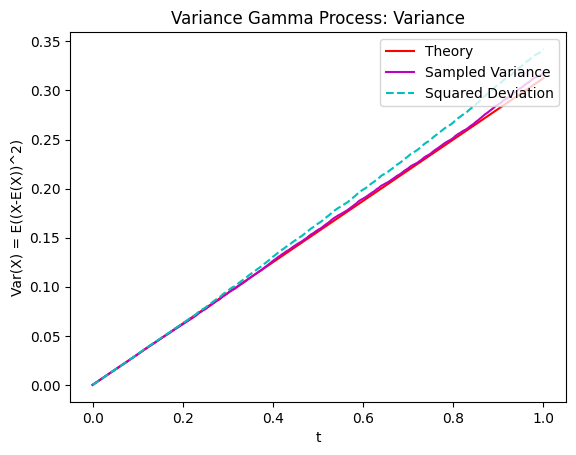

In [6]:
# Variance = mean square deviation
plt.figure()
var_ = t*(sigma**2+2*lamb*(p/(eta1**2)+(1-p)/(eta2**2)))

# VARX = t * (sigma**2 + 2 * lambda_ * (p / (eta1**2) + (1 - p) / (eta2**2)))
# # Sample variance (now along paths, axis 1)
# sampled_variance = np.var(X, axis=1)
# # Mean square deviation (now along paths, axis 1)
# mean_square_deviation = np.mean((X - EX[:, np.newaxis])**2, axis=1)

plt.plot(t, var_, 'r', label='Theory')
plt.plot(t, np.var(S, axis=1), 'm', label='Sampled Variance')
plt.plot(t, np.mean((S - EX[:, np.newaxis])**2, axis=1), 'c--', label='Squared Deviation')
plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('Var(X) = E((X-E(X))^2)')
plt.title('Variance Gamma Process: Variance')

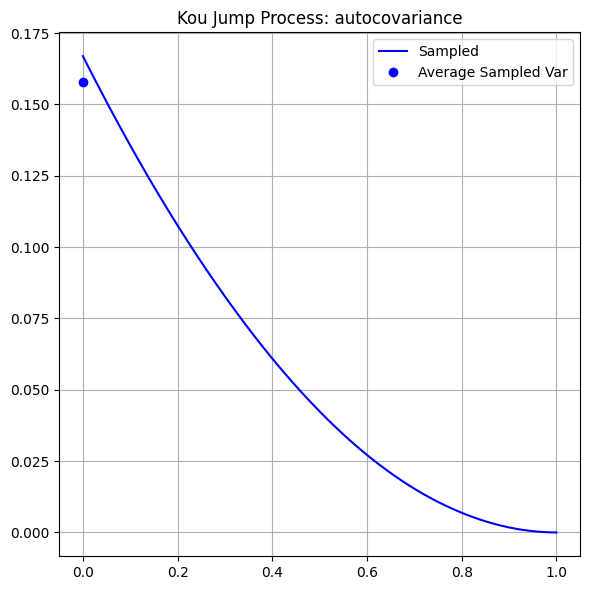

In [7]:
## Autocovariance
from scipy.signal import correlate
# Initialize the autocovariance array
C = np.zeros((npaths, 2 * nsteps+1))

# Calculate the autocovariance for each path
for i in range(npaths):
    deviation = S[:, i] - EX
    # Compute autocorrelation and normalize by the number of steps
    C[i, :] = correlate(deviation, deviation, mode='full') / nsteps
# Average over all paths
C = np.mean(C, axis=0)

plt.figure(figsize=(6, 6))
t = np.linspace(0, T, nsteps+1)

# Plot theoretical autocovariance - sigma^2 / (2 * alpha) * exp(-alpha * t)
# plt.plot(t, var_, 'r', label='Theory') 
# plt.plot(0, (sigma**2 + 2 * lamb * (p / eta1**2 + (1 - p) / eta2**2)) * 0, 'ro', label='Var for infinite t')

# Plot sampled autocovariance - plot second half since it's symmetric and the first half corresponds to negative lags
plt.plot(t, C[nsteps:], 'b', label='Sampled')
plt.plot(0, np.mean(np.var(S, axis=1)), 'bo', label='Average Sampled Var', linewidth=1.5) # average sampled variance

plt.legend(loc=0)
plt.title('Kou Jump Process: autocovariance')
plt.tight_layout()
plt.grid()

### Simulating the Jump according to Asymmetric double-sided exponential distribution

Text(0.5, 1.0, 'Asymmetric double-sided distribution')

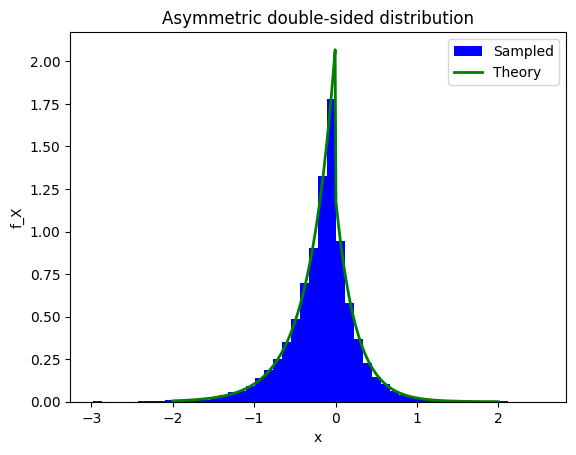

In [8]:
# As used in S. G. Kou, A jump diffusion model for option pricing,
# Management Science 48, 1086-1101, 2002, https://doi.org/10.1287/mnsc.48.8.1086.166
# See also Ballotta and Fusai (2018), Section 6.2.2

# Parameters
# lamda mu and vol??
eta1 = 4 #param of exp dist controlling upward jumps, mean upward is then 1/eta1
eta2 = 3 #param of exp dist controlling downward jumps, ^ 1/eta2
p = 0.3 #prob of upward jump
xmax = 2  #truncation
deltax = 0.01 #grid step
nsteps = int((xmax/deltax)*2) 
binw = 0.1 # bin width
n = 10000 # number of random samples

## Compute the PDF
x = np.linspace(-xmax,xmax,nsteps) #grid
fX = p*eta1*np.exp(-eta1*x)*(x>=0) + (1-p)*eta2*np.exp(eta2*x)*(x<0) #PDF

# Sampled Dist
U = np.random.rand(n) #standard uniform random variable
y = U>=1-p
X = -1/eta1*np.log((1-U)/p)*(U>=1-p)+1/eta2*np.log(U/(1-p))*(U<1-p) #bilateral exp. r.v.

## Plot
plt.figure()
plt.hist(X,bins=50,density=True, label='Sampled', color='b')
plt.plot(x,fX,lw=2, label='Theory', color='green')
plt.xlabel('x')
plt.ylabel('f_X')
plt.legend(loc=0)
plt.title('Asymmetric double-sided distribution')

In [9]:
class Kou_Jump_Diffusion_Process:
    """S = mu*t +sigma*W(t) + sum_{i=1}^{N(t)} Z_i
    Model describes stock price with continuous movement that have rare large jumps, with the jump sizes following a double 
    exponential distribution
    Requires numpy, pandas and plotly.express"""
    def __init__(self, mu, sigma, lambdaN, eta1, eta2, p, n_paths, n_steps, t, T, S_0):
        self.mu = mu
        self.sigma = sigma
        self.lambdaN = lambdaN
        self.eta1 = eta1
        self.eta2 = eta2
        self.p = p
        self.n_paths = n_paths
        self.n_steps = n_steps
        self.t = t
        self.T =T
        self.S_0 = S_0
    
    def get_paths(self):
        """Returns the paths, S, for the Kou Jump-Diffusion Process"""
        dt = self.T/self.n_steps
        dX = (self.mu-0.5*self.sigma**2)*dt + self.sigma*np.sqrt(dt)*np.random.randn(self.n_steps, self.n_paths)
        dP = np.random.poisson(self.lambdaN*dt, (self.n_steps, self.n_paths))
        
        #Bilateral Exponential R.V.       
        U = np.random.uniform(0,1, (self.n_steps, self.n_paths))
        Z = np.zeros((self.n_steps, self.n_paths))
        for i in range(0, len(U[0])):
            for j in range(0, len(U)):
                if U[j,i]>=self.p:
                    Z[j,i]=(-1/self.eta1)*np.log((1-U[j,i])/self.p)
                elif U[j,i]<self.p:
                    Z[j,i]=(1/self.eta2)*np.log(U[j,i]/(1-self.p))
        
        
        dJ = (np.exp(Z)-1)*dP
        dS = dX + dJ
        
        dS = np.insert(dS, 0, self.S_0, axis=0)
        S = np.cumsum(dS, axis=0)
        
        return S
    
    def get_expectation(self):
        """Returns the expectation, E[S], for the Kou Jump-Diffusion Process"""
        ES = (self.mu+self.lambdaN*(self.p/self.eta1-(1-self.p)/self.eta2))*t+self.S_0
        return ES
    
    def get_variance(self):
        """Returns the variance, Var[S], for the Kou Jump-Diffusion Process"""
        VarS = (self.sigma**2+2*self.lambdaN*(self.p/(self.eta1**2)+(1-self.p)/(self.eta2**2)))*t
        return VarS
    
    def simulate(self, plot_expected=False):
        """Returns the plot of the random paths taken by the Kou Jump-Diffusion Process"""
        plotting_df = pd.DataFrame(self.get_paths())
        if plot_expected==True:
            plotting_df["Expected Path"]=self.get_expectation()
        fig = px.line(plotting_df, labels={"value":"Value of S", "variable":"Paths"})
        return fig.show()

In [1]:
kjd = Kou_Jump_Diffusion_Process(mu,sigma,lamb,eta1,eta2,p,10,nsteps,t,T,S0)
kjd.simulate(plot_expected=True)